<h1> Data Preprocessing <h1>

In [140]:
import pandas as pd 
from datetime import datetime
# pd.set_option('display.max_rows',None)

#get input
receivedFileName="resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv"
resaleFlatDF = pd.read_csv(receivedFileName, encoding = "ISO-8859-1")


# df = pd.DataFrame(data = resaleFlat)


# df = df.sort_values(by=['street_name'])
# df["point_of_interest"] = 0
# df = df.reset_index(drop=True)


type(resaleFlatDF)
resaleFlatDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5 ROOM,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,95 years 03 months,610000.0
100643,2021-06,YISHUN,EXECUTIVE,664,YISHUN AVE 4,01 TO 03,181.0,Apartment,1992,69 years 11 months,868000.0
100644,2021-06,YISHUN,EXECUTIVE,277,YISHUN ST 22,01 TO 03,152.0,Maisonette,1985,63 years 03 months,585000.0
100645,2021-06,YISHUN,EXECUTIVE,643,YISHUN ST 61,01 TO 03,146.0,Maisonette,1987,65 years 04 months,600000.0


Retrieve accurate year left for remaining_lease based on the year the data is entered

In [141]:
for i, row in resaleFlatDF.iterrows():
   # datetime_object = datetime(2020, 2 ,2)
    year = int(row["remaining_lease"].split("years")[0])
    startDatetime = datetime.strptime(row["month"], '%Y-%m')
    #get the end date value
    currentDate = datetime.now()
    numberOfYears = (startDatetime.year + year - currentDate.year)
    resaleFlatDF.at[i, 'remaining_lease'] = numberOfYears
resaleFlatDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,57,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,56,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,58,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,58,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,58,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5 ROOM,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,95,610000.0
100643,2021-06,YISHUN,EXECUTIVE,664,YISHUN AVE 4,01 TO 03,181.0,Apartment,1992,69,868000.0
100644,2021-06,YISHUN,EXECUTIVE,277,YISHUN ST 22,01 TO 03,152.0,Maisonette,1985,63,585000.0
100645,2021-06,YISHUN,EXECUTIVE,643,YISHUN ST 61,01 TO 03,146.0,Maisonette,1987,65,600000.0


Flat type, storey_range and flat model is convert to numerical for categorisation <br>
Resale price is categorised to every \$100,000 or bigger than \$1,000,000 <br>
Remaining lease is categorised to every decade <br>

In [142]:
import math
#price interval every 100000, when above 1000000 just display above 1000000
flatType = sorted(resaleFlatDF["flat_type"].drop_duplicates())
flatType
i = 1 
for x in flatType:
    resaleFlatDF["flat_type"] = resaleFlatDF["flat_type"].replace([x],i)
    i = i + 1   

storeyRange = sorted(resaleFlatDF["storey_range"].drop_duplicates())
storeyRange
i = 1 
for x in storeyRange:
    resaleFlatDF["storey_range"] = resaleFlatDF["storey_range"].replace([x],i)
    i = i + 1 
    
flatModel = sorted(resaleFlatDF["flat_model"].drop_duplicates())
flatModel
i = 1 
for x in flatModel:
    resaleFlatDF["flat_model"] = resaleFlatDF["flat_model"].replace([x],i)
    i = i + 1   
#price categorise
resaleFlatDF['resale_price'] = resaleFlatDF['resale_price'].apply(lambda x: math.ceil(x/100000) if x < 1000000 else 11)

#remaining lease categorise
resaleFlatDF['remaining_lease'] = resaleFlatDF['remaining_lease'].apply(lambda x: math.ceil(x/10))
resaleFlatDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2,406,ANG MO KIO AVE 10,4,44.0,5,1979,6,3
1,2017-01,ANG MO KIO,3,108,ANG MO KIO AVE 4,1,67.0,12,1978,6,3
2,2017-01,ANG MO KIO,3,602,ANG MO KIO AVE 5,1,67.0,12,1980,6,3
3,2017-01,ANG MO KIO,3,465,ANG MO KIO AVE 10,2,68.0,12,1980,6,3
4,2017-01,ANG MO KIO,3,601,ANG MO KIO AVE 5,1,67.0,12,1980,6,3
...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5,511A,YISHUN ST 51,4,113.0,5,2017,10,7
100643,2021-06,YISHUN,6,664,YISHUN AVE 4,1,181.0,3,1992,7,9
100644,2021-06,YISHUN,6,277,YISHUN ST 22,1,152.0,7,1985,7,6
100645,2021-06,YISHUN,6,643,YISHUN ST 61,1,146.0,7,1987,7,6


All these variables does not define the flat <br>
Except for floor_area_sqm which is based on the flat type. Hence it is redundant

In [143]:
resaleFlatDF = resaleFlatDF.drop(['month','town','block','floor_area_sqm','street_name','lease_commence_date'], axis=1)
resaleFlatDF

,flat_type,storey_range,flat_model,remaining_lease,resale_price
0,2,4,5,6,3
1,3,1,12,6,3
2,3,1,12,6,3
3,3,2,12,6,3
4,3,1,12,6,3
...,...,...,...,...,...
100642,5,4,5,10,7
100643,6,1,3,7,9
100644,6,1,7,7,6
100645,6,1,7,7,6


In [144]:
resaleFlatGroupDF = resaleFlatDF.groupby(["flat_type","storey_range","flat_model","remaining_lease","resale_price"])
resaleFlatDF["Class"] = 0
category = pd.DataFrame(columns=["flat_type","storey_range","flat_model","remaining_lease","resale_price","Class"])

for i, (key, df) in enumerate(resaleFlatGroupDF):
    category = category.append({"flat_type": key[0],"storey_range": key[1],"flat_model": key[2],"remaining_lease": key[3],"resale_price": key[4], "Class": i}, ignore_index = True)
    for row in df.iterrows():
        resaleFlatDF.loc[row[0], 'Class'] = i
print(category)
resaleFlatDF

     flat_type storey_range flat_model remaining_lease resale_price Class
0            1            1          5               6            2     0
1            1            1          5               6            3     1
2            1            2          5               6            2     2
3            1            2          5               6            3     3
4            1            3          5               6            2     4
...        ...          ...        ...             ...          ...   ...
2470         7            3         11               7            9  2470
2471         7            4         11               7            7  2471
2472         7            4         11               7            8  2472
2473         7            4         11               7            9  2473
2474         7            4         11               7           10  2474

[2475 rows x 6 columns]


,flat_type,storey_range,flat_model,remaining_lease,resale_price,Class
0,2,4,5,6,3,87
1,3,1,12,6,3,170
2,3,1,12,6,3,170
3,3,2,12,6,3,242
4,3,1,12,6,3,170
...,...,...,...,...,...,...
100642,5,4,5,10,7,1734
100643,6,1,3,7,9,2224
100644,6,1,7,7,6,2235
100645,6,1,7,7,6,2235


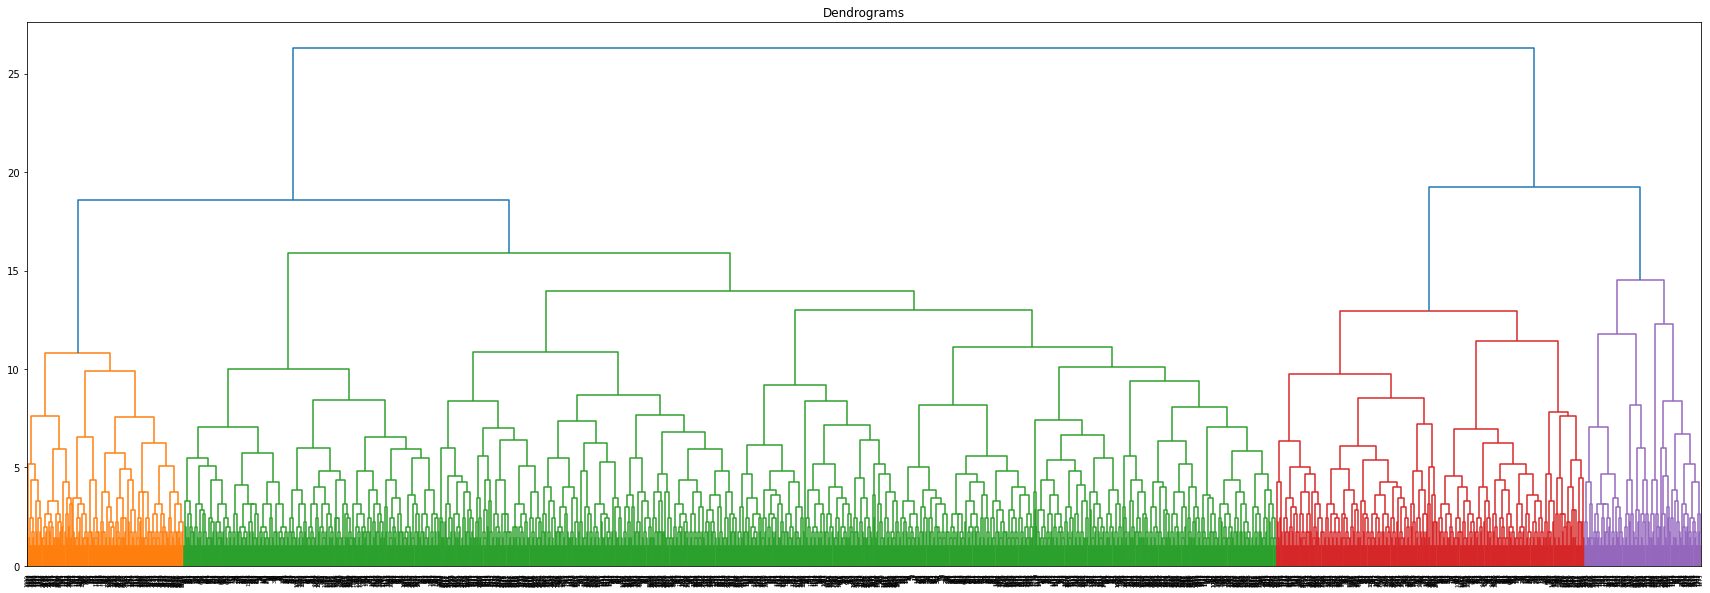

In [145]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,10)) 
plt.title("Dendrograms")  
names = category['Class']
Y = category['Class']
X = category.drop(['Class'],axis=1)
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

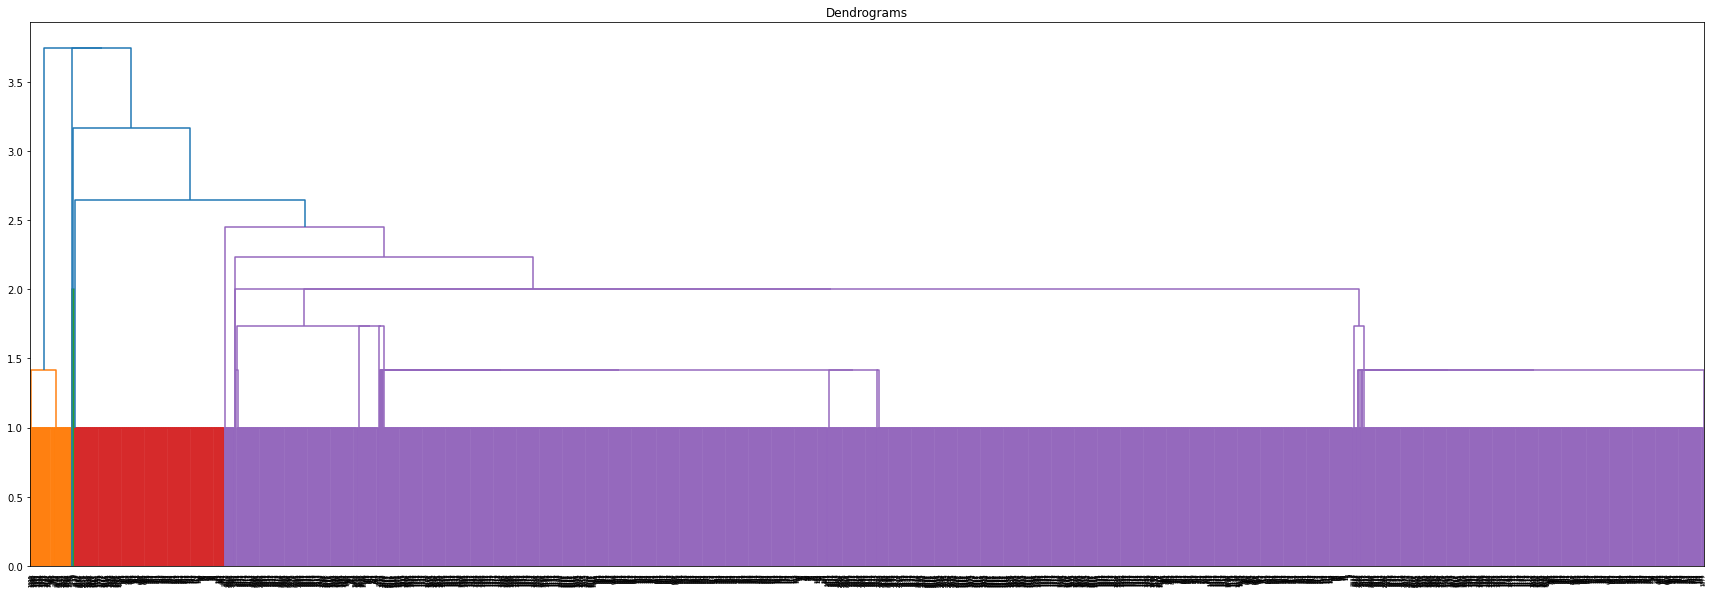

In [146]:
plt.figure(figsize=(30,10)) 
plt.title("Dendrograms")  
names = category['Class']
Y = category['Class']
X = category.drop(['Class'],axis=1)
Z = hierarchy.linkage(X, 'single')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

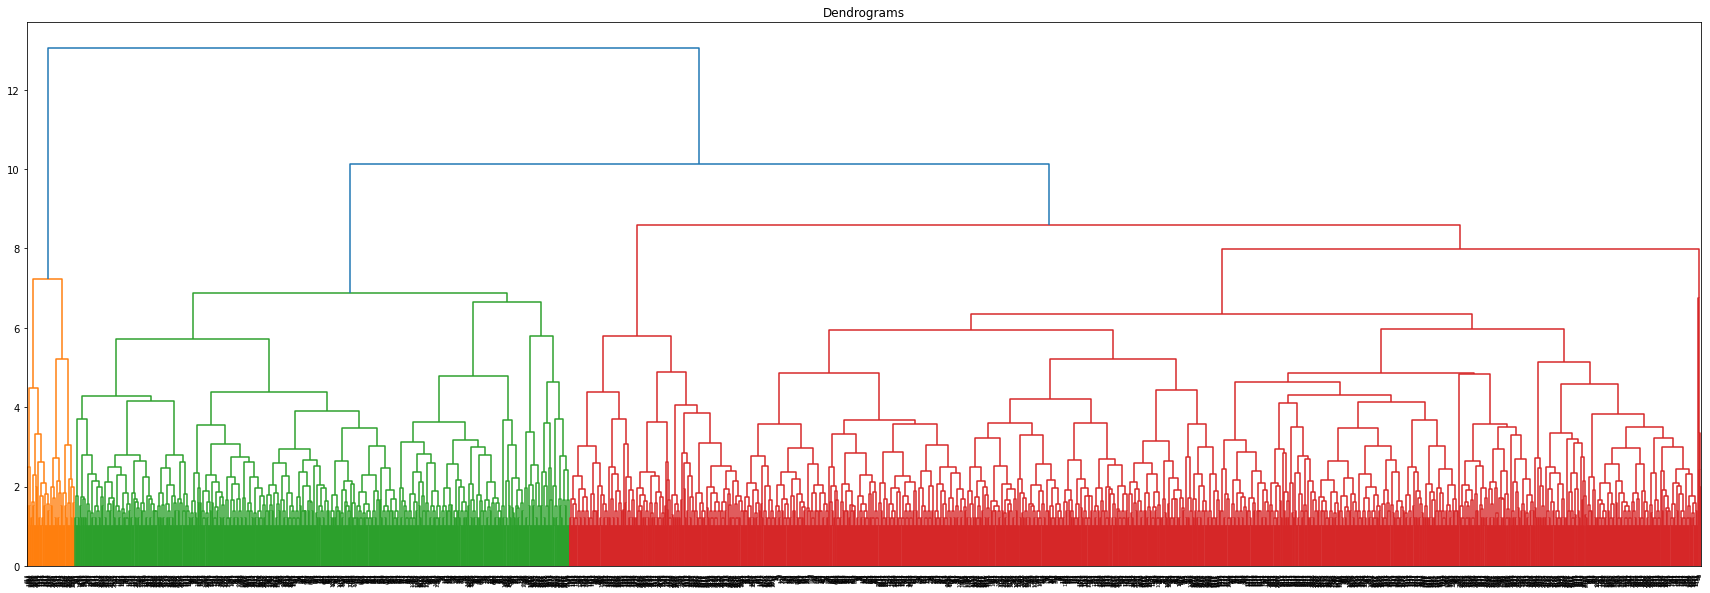

In [147]:
plt.figure(figsize=(30,10)) 
plt.title("Dendrograms")  
names = category['Class']
Y = category['Class']
X = category.drop(['Class'],axis=1)
Z = hierarchy.linkage(X, 'average') #An (n−1) by 4 matrix Z is returned
dn = hierarchy.dendrogram(Z,labels=names.tolist())

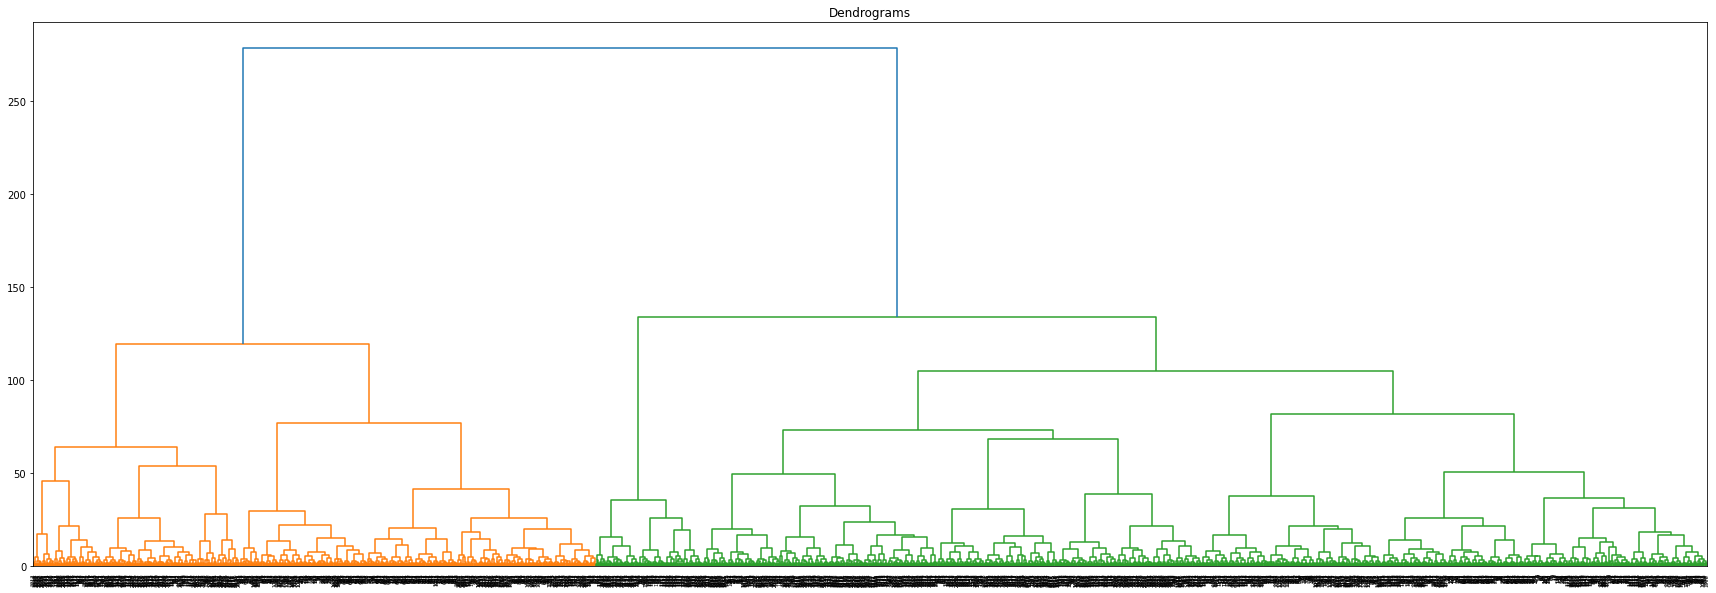

In [148]:
plt.figure(figsize=(30,10)) 
plt.title("Dendrograms")  
names = category['Class']
Y = category['Class']
X = category.drop(['Class'],axis=1)
Z = hierarchy.linkage(X, 'ward')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

<h1> @Qi Rong can explain here why we choose complete and below i plot a line "The vertical line with maximum distance is the most left blue line and hence we can decide a threshold of 17 and cut the dendrogram" <h1>

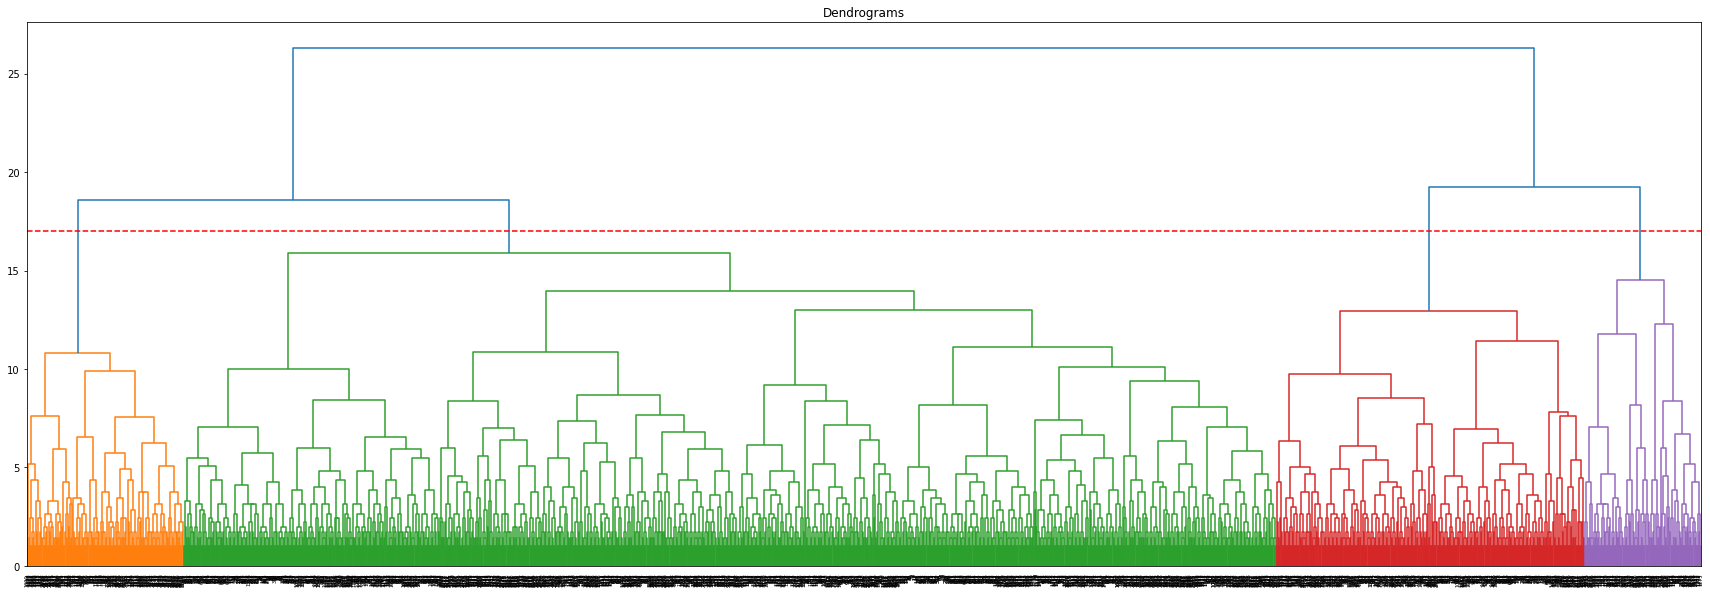

In [149]:
plt.figure(figsize=(30,10)) 
plt.title("Dendrograms")  
names = category['Class']
Y = category['Class']
X = category.drop(['Class'],axis=1)
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist())
plt.axhline(y=17, color='r', linestyle='--')

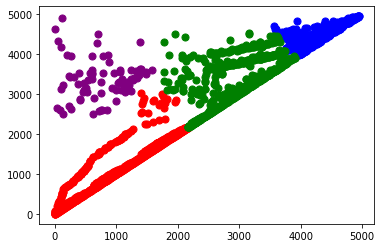

In [150]:
from sklearn.cluster import AgglomerativeClustering
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
cluster.fit_predict(Z)
labels = cluster.labels_

plt.scatter(Z[labels==0, 0], Z[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(Z[labels==1, 0], Z[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(Z[labels==2, 0], Z[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(Z[labels==3, 0], Z[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(Z[labels==4, 0], Z[labels==4, 1], s=50, marker='o', color='orange')
plt.show()



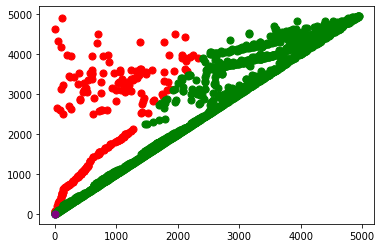

In [151]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='complete')  
cluster.fit_predict(category)
cluster.fit_predict(Z)
labels = cluster.labels_
plt.scatter(Z[labels==0, 0], Z[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(Z[labels==1, 0], Z[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(Z[labels==2, 0], Z[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(Z[labels==3, 0], Z[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(Z[labels==4, 0], Z[labels==4, 1], s=50, marker='o', color='orange')

<h1> @Kwang The cosine similarity look pretty fked<h1>

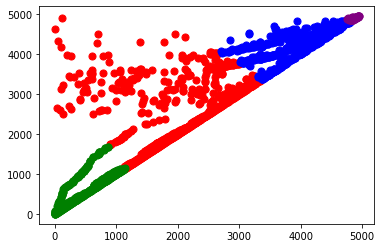

In [158]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='manhattan', linkage='complete')  
cluster.fit_predict(category)
cluster.fit_predict(Z)
labels = cluster.labels_

plt.scatter(Z[labels==0, 0], Z[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(Z[labels==1, 0], Z[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(Z[labels==2, 0], Z[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(Z[labels==3, 0], Z[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(Z[labels==4, 0], Z[labels==4, 1], s=50, marker='o', color='orange')

<H1> @Kwang I realised you are visualisation, so this should be wen hui job.<br>
@Wen hui, both manhatten and eclidean look pretty decent. <H1>

In [160]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
len(cluster.fit_predict(Z))

2474

In [156]:
print(len(category))
len(Z)
# for i, label in enumerate(Z):
#     category.loc[i, 'Label'] = label
# category
# resaleFlatDF.loc[row[0], 'Class'] = i

2475


2474